In [62]:
!pip install gdown
!pip install tqdm

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from tqdm import tqdm
import copy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [63]:
# @title Download MoNuSeg Training Data and Convert Masks
import gdown
import os
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET
from skimage.draw import polygon

def parse_xml_to_mask(xml_path, image_size):

  width, height = image_size
  mask = np.zeros((height, width), dtype=np.uint8)

  tree = ET.parse(xml_path)
  root = tree.getroot()

  for region in root.findall('.//Region'):
    for vertices in region.findall('.//Vertices'):
      row_cords = []
      col_cords = []
      for vertex in vertices.findall('.//Vertex'):
        x = float(vertex.get('X'))
        y = float(vertex.get('Y'))

        row_cords.append(y)
        col_cords.append(x)

      rr, cc = polygon(row_cords, col_cords, (height, width))
      mask[rr, cc] = 1

  return mask

if not os.path.exists('MoNuSeg'):
  # -c to skip if already downloaded. MoNuSeg is hosted on google drive
  gdown.download(id = "1ZgqFJomqQGNnsx7w7QBzQQMVA16lbVCA", output = "MoNuSeg.zip")
  !unzip MoNuSeg.zip -d MoNuSeg
  !rm MoNuSeg.zip

  os.mkdir('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Annotations')
  os.mkdir('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Images')

  # Convert masks to 1,000 by 1,000 px pngs
  for file in os.listdir('MoNuSeg/MoNuSeg 2018 Training Data/Annotations'):
    if file.endswith('.xml'):
      xml_path = os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Annotations', file)
      mask = parse_xml_to_mask(xml_path, (1000, 1000))
      mask = Image.fromarray(mask)
      mask.save(os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Annotations', file[:-4] + '.png'))
  # Convert compressed tiff to png for faster loading
  for file in os.listdir('MoNuSeg/MoNuSeg 2018 Training Data/Tissue Images'):
    if file.endswith('.tif'):
      img_path = os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Tissue Images', file)
      img = Image.open(img_path)
      img.save(os.path.join('MoNuSeg/MoNuSeg 2018 Training Data/Proccessed Images', file[:-4] + '.png'))

else:
  print("MoNuSeg Training Data already downloaded")

MoNuSeg Training Data already downloaded


In [64]:
# @title MoNuSeg Data Set
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import v2
from torchvision import tv_tensors


class MoNuSegDataset(Dataset):
  def __init__(self, root_dir, transform = None, bright_contrast = False):
    """
    Args:
        root_dir (string): Directory with all the images and masks.
        transform (callable, optional): Optional transform to be applied
            on a sample. Default is random 256x256 crop.
    """
    self.root_dir = root_dir
    self.image_dir = os.path.join(root_dir, 'Proccessed Images')
    self.mask_dir = os.path.join(root_dir, 'Proccessed Annotations')

    # transform both img and mask for data augmentation
    if transform is None:
      transform = v2.RandomCrop((256,256))
    
    self.transform = transform

    # setting up data type
    self.img_transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

    if bright_contrast:
        self.img_transform = v2.Compose([v2.ToImage(), v2.ColorJitter(brightness=0.2, contrast=0.2), v2.ToDtype(torch.float32, scale=True)])

    # Sort to ensure images and masks match
    self.images = sorted(os.listdir(self.image_dir))
    self.masks = sorted(os.listdir(self.mask_dir))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = Image.open(os.path.join(self.image_dir, self.images[idx]))
    mask = Image.open(os.path.join(self.mask_dir, self.masks[idx]))

    # manual transform each for image and mask separately
    img = self.img_transform(img)
    mask = tv_tensors.Mask(mask)
    
    img, mask = self.transform(img, mask)

    mask = mask.squeeze(0) # Remove the channel dimension. It's a channel size of 1 anyway

    return {"image": img, "mask": mask}

In [65]:
# @title Create Dataloader
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data')

# Pin memory to speed up loading to GPU. Increase # workers
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)

Number of train samples: 37


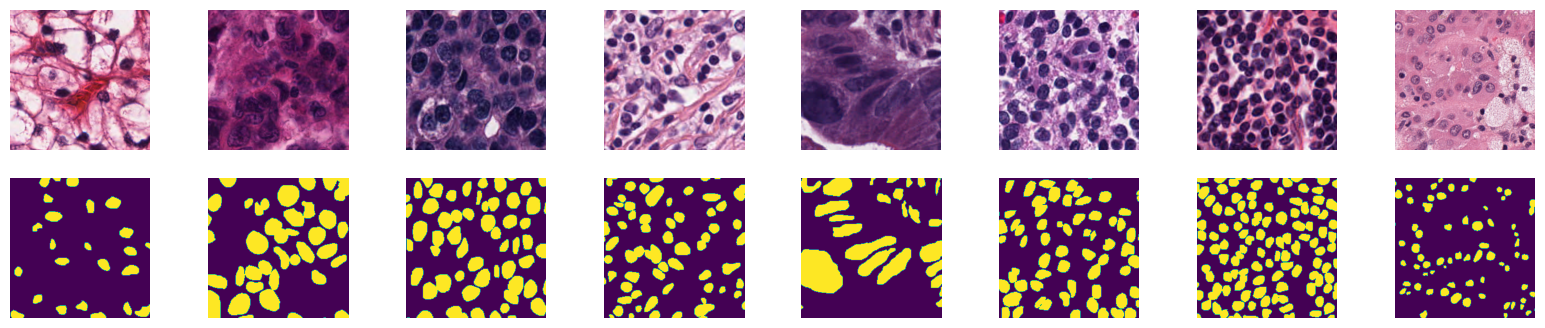

In [66]:
# @title Visualize Batch

images = next(iter(dataloader))

print(f"Number of train samples: {len(dataset)}")

fig, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(8):
  axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
  axes[0,i].axis('off')
  axes[1,i].imshow(images["mask"][i])
  axes[1,i].axis('off')

plt.show()

In [67]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [68]:
# @title Define the UNet

import torch
import torch.nn as nn

class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        pooled_x = self.pool(x)

        return pooled_x, x # need to return both pooled and pre-pooled for skip connections

class ExpansiveBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpansiveBlock, self).__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')

    def forward(self, pooled_x, pre_x):
        pooled_x = self.up_conv(pooled_x)

        diff_Y = pre_x.size()[2] - pooled_x.size()[2]
        diff_X = pre_x.size()[3] - pooled_x.size()[3]
        x_cropped = pre_x[:, :, diff_Y // 2 : pre_x.size()[2] - diff_Y // 2,
                                    diff_X // 2 : pre_x.size()[3] - diff_X // 2]

        x = torch.cat([pooled_x, x_cropped], dim=1) # add across the channel dimensions to double the channel count

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x
        

class UNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(UNet, self).__init__()

        # Contracting Path
        self.contract1 = ContractingBlock(3, 64)
        self.contract2 = ContractingBlock(64, 128)
        self.contract3 = ContractingBlock(128, 256)
        self.contract4 = ContractingBlock(256, 512)

        # Bottleneck Layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding='same'),
            nn.ReLU()             
        )
        
        # Expansive Path
        self.expand1 = ExpansiveBlock(1024, 512)
        self.expand2 = ExpansiveBlock(512, 256)
        self.expand3 = ExpansiveBlock(256, 128)
        self.expand4 = ExpansiveBlock(128, 64)

        # Final layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1, stride=1, padding='same')

    def forward(self, x):
        x, x_skip1 = self.contract1(x)
        x, x_skip2 = self.contract2(x)
        x, x_skip3 = self.contract3(x)
        x, x_skip4 = self.contract4(x)

        x = self.bottleneck(x)

        x = self.expand1(x, x_skip4)
        x = self.expand2(x, x_skip3)
        x = self.expand3(x, x_skip2)
        x = self.expand4(x, x_skip1)

        x = self.final_conv(x)
        
        return x


In [122]:
# @title Initialize Model (Untrained Model)

untrained_model = UNet()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [123]:
# @title Run on Samples

output = untrained_model(images['image'])

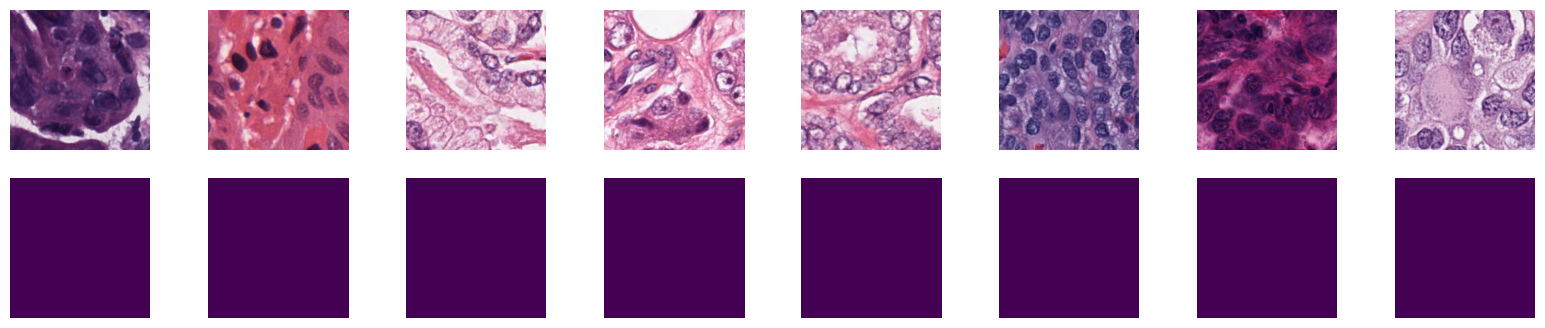

In [124]:
# @title Visualize First Batch Output (No training)
out_mask = (torch.softmax(output, dim = 1)[:,1,:,:].detach() > .5).float()

fig, axes = plt.subplots(2, 8, figsize=(20, 4))
for i in range(8):
  axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
  axes[0,i].axis('off')
  axes[1,i].imshow(out_mask[i])
  axes[1,i].axis('off')

plt.show()

In [69]:
# @title Define Accuracy Function - Pixel Accuracy

def pixel_accuracy(pred, target):
    pred_classes = torch.argmax(pred, dim=1)  # pred = raw output from the model. convert [B, C=2, H, W] to [B, H, W] and collapsing dim=1, basically generating the mask.
    
    correct = (pred_classes == target).float()  # target = ground truth. correct = [B, H, W], 1.0 if correct else 0.0
    
    accuracy = correct.sum() / correct.numel()  # total correct / total pixels = pixel accuracry
    
    return accuracy.item() # extract the float without other info associated with the tensor

In [76]:
# @title Define Accuracy Function - Dice Score

def dice_score(pred, target, smooth=1e-6):
    num_classes = pred.shape[1] # 2nd dim of the predicted mask, which is num_classes
    
    # convert all numbers according to the probability of the num_classes (across the C dimension of [B, C, H, W]
    pred = torch.softmax(pred, dim=1)

    # one-hot encoding the target (ground truth) to match the output
    target_one_hot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float() 

    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    
    return dice.mean()

In [77]:
# @title Define Training Loop

def train(epochs, model, loss_fn, optimizer, train_loader, val_loader, lr_scheduler = None, name="iforgotoname"):
    best_dice_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"): # add progress bar
            img = batch['image'].to(device=device, dtype=torch.float32)
            mask = batch['mask'].to(device=device, dtype=torch.int64)
    
            predicted_mask = model(img)
    
            loss = loss_fn(predicted_mask, mask)
    
            optimizer.zero_grad()
    
            loss.backward()
    
            optimizer.step()
    
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        # print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}")
    
        # Validation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch in val_loader:
                img = batch['image'].to(device=device, dtype=torch.float32)
                mask = batch['mask'].to(device=device, dtype=torch.int64)
    
                predicted_mask = model(img)
                
                loss = 1 - dice_score(predicted_mask, mask) # we only care about dice loss for validation: for recognizing nuclei correctly
                
                val_loss += loss.item()
    
        avg_val_loss = val_loss / len(val_loader)

        if lr_scheduler: # will update the LR based on dice loss only during validation step
            lr_scheduler.step(avg_val_loss)
            
            for param_group in optimizer.param_groups:
                print(f"Current Learning Rate: {param_group['lr']:.6f}")
                
        # print(f"Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {avg_acc:.4f}")

        if avg_val_loss < best_dice_loss:
            best_dice_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            # print(f"New best model saved (Accuracy: {avg_acc:.4f})")

    if best_model_state is not None:
        torch.save(best_model_state, f"{name}_best_model.pt")
        # print(f"Best model saved with accuracy {best_val_acc:.4f}")

    return best_dice_loss

In [78]:
# @title Define Visualization 

def show_pic(model, images, name="iforgottoname"):
    model.load_state_dict(torch.load(f"{name}_best_model.pt"))
    model = model.to(device)
    model.eval()

    output_trained = model(images['image'].to(device=device))
    
    out_mask_trained = (torch.softmax(output_trained, dim = 1)[:,1,:,:].cpu() > .5).float()
    
    fig, axes = plt.subplots(3, 8, figsize=(20, 4))
    for i in range(8):
      axes[0,i].imshow(images["image"][i].permute(1, 2, 0))
      axes[0,i].axis('off')
      axes[1,i].imshow(out_mask_trained[i])
      axes[1,i].axis('off')
      axes[2,i].imshow(images["mask"][i])
      axes[2,i].axis('off')
    
    plt.show()

In [80]:
# @title Create a New Instance of Model to train

total_ce_acc = 0.0

for i in range(5):
    
    model = UNet()
    
    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    total_ce_acc += train(epochs, model, F.cross_entropy, optimizer, train_loader, val_loader, name="cross_entropy")

print(f"Average model dice loss for trained with Cross Entropy Loss is {total_ce_acc/10:.4f}")


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


Average model dice loss for trained with Cross Entropy Loss is 0.1601


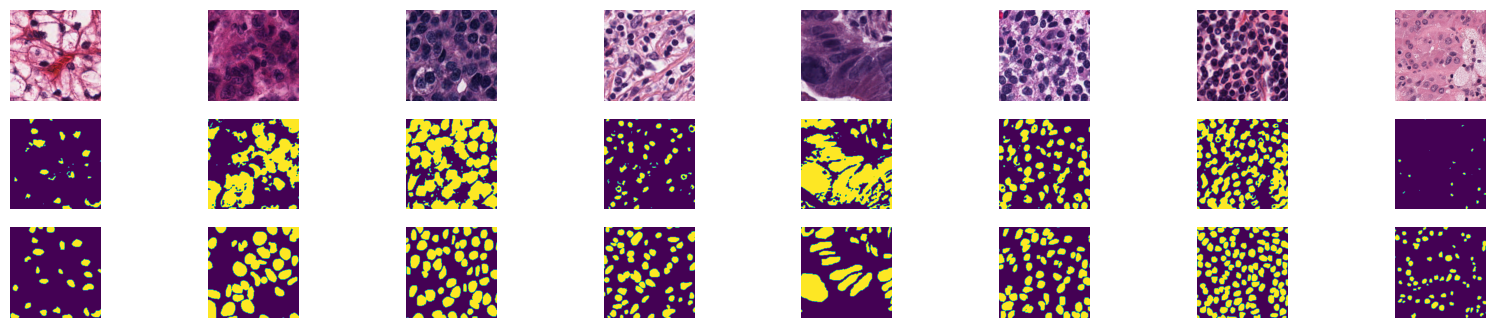

In [81]:
# @title Visualize After 20 Epoch

show_pic(model, images, name="cross_entropy")

In [82]:
# @title try the same thing but with Dice Loss instead of CrossEntropy Loss

def multiclass_dice_loss(pred, target, smooth=1e-5):
    num_classes = pred.shape[1] # 2nd dim of the predicted mask, which is num_classes
    
    # convert all numbers according to the probability of the num_classes (across the C dimension of [B, C, H, W]
    pred = torch.softmax(pred, dim=1)

    # one-hot encoding the target (ground truth) to match the output
    target_one_hot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float() 

    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

In [84]:
# @title Dice Loss

total_multi_dice_acc = 0.0

for i in range(5):
    
    model = UNet()

    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    total_multi_dice_acc += train(epochs, model, multiclass_dice_loss, optimizer, train_loader, val_loader, name="multiclass_dice")

print(f"Average model dice loss for trained with Multiclass Dice Loss is {total_multi_dice_acc/10:.4f}")
      

Average model dice loss for trained with Multiclass Dice Loss is 0.1165


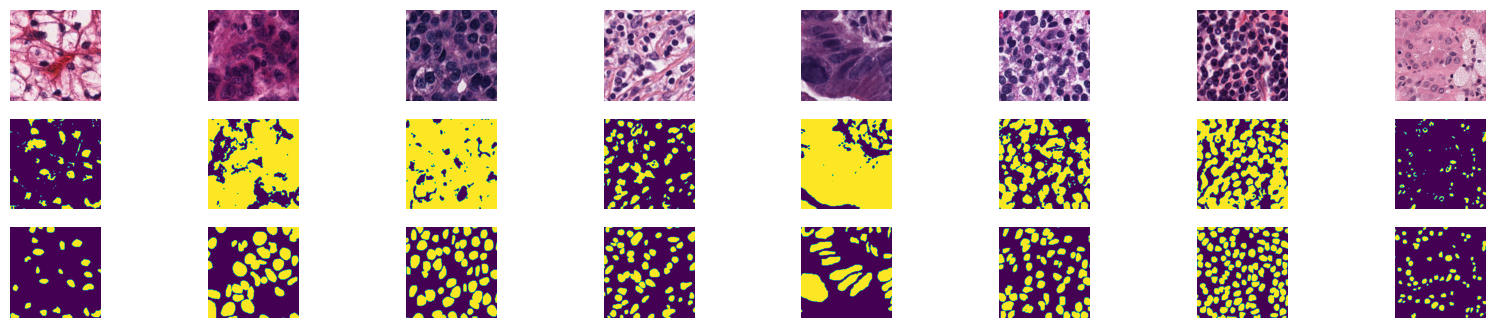

In [85]:
# Visualize after 20 Epochs: Trained using Dice Loss

show_pic(model, images, name="multiclass_dice")

In [32]:
# @title Hybrid Loss Function: Dice Loss + CrossEntropy

def hybrid_loss(pred, target, dice_weight=0.5):

    # CrossEntropy Loss
    ce = F.cross_entropy(pred, target)

    # Multiclass Dice Loss
    dice_loss = multiclass_dice_loss(pred, target)

    return (1 - dice_weight) * ce + dice_weight * dice_loss

In [61]:
# @title Use Hybrid Loss Function

total_hybrid_acc = 0.0

for i in range(10):
    model = UNet()

    # do random split to set aside validation set
    train_dataset, val_dataset = random_split(dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    total_hybrid_acc += train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, name="hybrid_loss")

print(f"Average model accuracy for Hybrid Loss is {total_hybrid_acc/10:.4f}")
      

Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Average model accuracy for Hybrid Loss is 0.8625


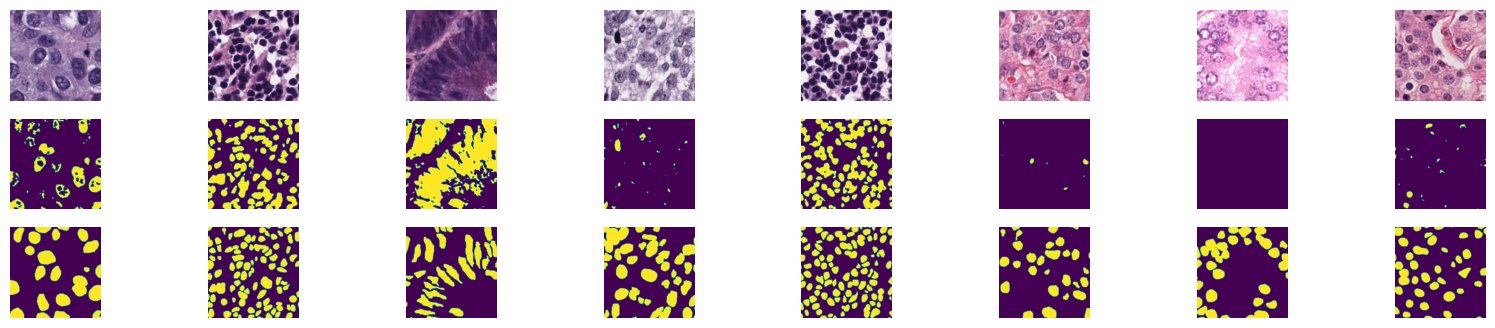

In [36]:
# Visualize after 20 Epochs: Trained using Hybrid Loss

show_pic(model, images, name="hybrid_loss")

In [37]:
# @title Additional Data Augmentation to Improve Overfitting Problem

# create a new dataset

transform = v2.Compose([v2.RandomCrop((256,256)), v2.RandomHorizontalFlip(), v2.RandomVerticalFlip(), v2.RandomRotation(180)])

aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform = transform)


model = UNet()

# do random split to set aside validation set
train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device=device)

train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, name="hybrid_loss_data_aug")

Epoch 1/20: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 1, Training Loss: 0.5511


Epoch 1, Validation Loss: 0.9167, Accuracy: 0.8295
New best model saved (Accuracy: 0.8295)


Epoch 2/20: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

Epoch 2, Training Loss: 0.6298


Epoch 2, Validation Loss: 0.4797, Accuracy: 0.8442
New best model saved (Accuracy: 0.8442)


Epoch 3/20: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

Epoch 3, Training Loss: 0.5056


Epoch 3, Validation Loss: 0.4796, Accuracy: 0.8142


Epoch 4/20: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

Epoch 4, Training Loss: 0.4783


Epoch 4, Validation Loss: 0.4485, Accuracy: 0.8017


Epoch 5/20: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

Epoch 5, Training Loss: 0.4436


Epoch 5, Validation Loss: 0.5709, Accuracy: 0.7560


Epoch 6/20: 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

Epoch 6, Training Loss: 0.4681


Epoch 6, Validation Loss: 0.4138, Accuracy: 0.8197


Epoch 7/20: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

Epoch 7, Training Loss: 0.4179


Epoch 7, Validation Loss: 0.3874, Accuracy: 0.7916


Epoch 8/20: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 8, Training Loss: 0.3993


Epoch 8, Validation Loss: 0.3912, Accuracy: 0.7998


Epoch 9/20: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

Epoch 9, Training Loss: 0.4034


Epoch 9, Validation Loss: 0.3412, Accuracy: 0.8243


Epoch 10/20: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 10, Training Loss: 0.3668


Epoch 10, Validation Loss: 0.3347, Accuracy: 0.8303


Epoch 11/20: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 11, Training Loss: 0.3840


Epoch 11, Validation Loss: 0.3269, Accuracy: 0.8894
New best model saved (Accuracy: 0.8894)


Epoch 12/20: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

Epoch 12, Training Loss: 0.3790


Epoch 12, Validation Loss: 0.2867, Accuracy: 0.9172
New best model saved (Accuracy: 0.9172)


Epoch 13/20: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 13, Training Loss: 0.3931


Epoch 13, Validation Loss: 0.3782, Accuracy: 0.8801


Epoch 14/20: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 14, Training Loss: 0.3841


Epoch 14, Validation Loss: 0.3682, Accuracy: 0.8496


Epoch 15/20: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 15, Training Loss: 0.3797


Epoch 15, Validation Loss: 0.3572, Accuracy: 0.8560


Epoch 16/20: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

Epoch 16, Training Loss: 0.3726


Epoch 16, Validation Loss: 0.3825, Accuracy: 0.8278


Epoch 17/20: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

Epoch 17, Training Loss: 0.3498


Epoch 17, Validation Loss: 0.2747, Accuracy: 0.9233
New best model saved (Accuracy: 0.9233)


Epoch 18/20: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

Epoch 18, Training Loss: 0.3307


Epoch 18, Validation Loss: 0.3353, Accuracy: 0.8783


Epoch 19/20: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 19, Training Loss: 0.3619


Epoch 19, Validation Loss: 0.3206, Accuracy: 0.8803


Epoch 20/20: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

Epoch 20, Training Loss: 0.3491


Epoch 20, Validation Loss: 0.3263, Accuracy: 0.8689
Best model saved with accuracy 0.9233


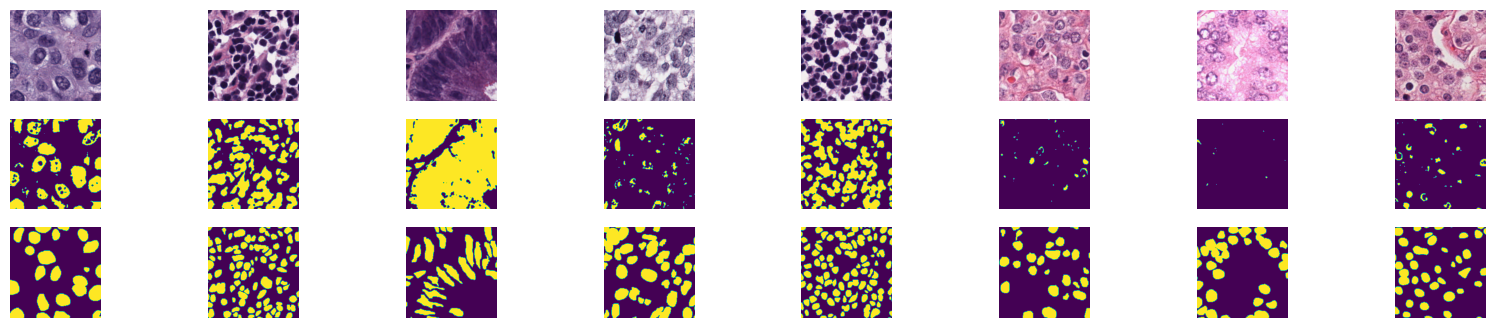

In [39]:
# @title Visualize after Data Augmentation

show_pic(model, images, name="hybrid_loss_data_aug")

In [43]:
    # @title Implement LR Scheduling to see if I can improve training stability
    
    model = UNet()
    
    aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform = transform)
    train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15]) 
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    epochs = 50 # increasing epochs
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    model = model.to(device=device)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler, name="hybrid_loss_data_aug_lr_scheduling")

Epoch 1/50: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

Epoch 1, Training Loss: 0.5718


Current Learning Rate: 0.001000
Epoch 1, Validation Loss: 0.7320, Accuracy: 0.7728
New best model saved (Accuracy: 0.7728)


Epoch 2/50: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Epoch 2, Training Loss: 0.5760


Current Learning Rate: 0.001000
Epoch 2, Validation Loss: 0.5131, Accuracy: 0.7714


Epoch 3/50: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

Epoch 3, Training Loss: 0.5077


Current Learning Rate: 0.001000
Epoch 3, Validation Loss: 0.4763, Accuracy: 0.7501


Epoch 4/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 4, Training Loss: 0.4823


Current Learning Rate: 0.001000
Epoch 4, Validation Loss: 0.4660, Accuracy: 0.7229


Epoch 5/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 5, Training Loss: 0.4451


Current Learning Rate: 0.001000
Epoch 5, Validation Loss: 0.3848, Accuracy: 0.7735
New best model saved (Accuracy: 0.7735)


Epoch 6/50: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Epoch 6, Training Loss: 0.4164


Current Learning Rate: 0.001000
Epoch 6, Validation Loss: 0.3628, Accuracy: 0.7561


Epoch 7/50: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

Epoch 7, Training Loss: 0.4027


Current Learning Rate: 0.001000
Epoch 7, Validation Loss: 0.3503, Accuracy: 0.7317


Epoch 8/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 8, Training Loss: 0.4026


Current Learning Rate: 0.001000
Epoch 8, Validation Loss: 0.3641, Accuracy: 0.7151


Epoch 9/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 9, Training Loss: 0.3965


Current Learning Rate: 0.001000
Epoch 9, Validation Loss: 0.3360, Accuracy: 0.7727


Epoch 10/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 10, Training Loss: 0.3786


Current Learning Rate: 0.001000
Epoch 10, Validation Loss: 0.3074, Accuracy: 0.8876
New best model saved (Accuracy: 0.8876)


Epoch 11/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 11, Training Loss: 0.4178


Current Learning Rate: 0.001000
Epoch 11, Validation Loss: 0.3073, Accuracy: 0.8962
New best model saved (Accuracy: 0.8962)


Epoch 12/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 12, Training Loss: 0.3827


Current Learning Rate: 0.001000
Epoch 12, Validation Loss: 0.3408, Accuracy: 0.8669


Epoch 13/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 13, Training Loss: 0.3665


Current Learning Rate: 0.001000
Epoch 13, Validation Loss: 0.3760, Accuracy: 0.8375


Epoch 14/50: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

Epoch 14, Training Loss: 0.3675


Current Learning Rate: 0.001000
Epoch 14, Validation Loss: 0.3389, Accuracy: 0.8716


Epoch 15/50: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

Epoch 15, Training Loss: 0.3688


Current Learning Rate: 0.001000
Epoch 15, Validation Loss: 0.3244, Accuracy: 0.8768


Epoch 16/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 16, Training Loss: 0.3484


Current Learning Rate: 0.001000
Epoch 16, Validation Loss: 0.6213, Accuracy: 0.7588


Epoch 17/50: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

Epoch 17, Training Loss: 0.4419


Current Learning Rate: 0.000500
Epoch 17, Validation Loss: 0.3499, Accuracy: 0.8381


Epoch 18/50: 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

Epoch 18, Training Loss: 0.3442


Current Learning Rate: 0.000500
Epoch 18, Validation Loss: 0.3080, Accuracy: 0.8731


Epoch 19/50: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Epoch 19, Training Loss: 0.3481


Current Learning Rate: 0.000500
Epoch 19, Validation Loss: 0.2892, Accuracy: 0.8796


Epoch 20/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 20, Training Loss: 0.3656


Current Learning Rate: 0.000500
Epoch 20, Validation Loss: 0.3033, Accuracy: 0.8744


Epoch 21/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 21, Training Loss: 0.3491


Current Learning Rate: 0.000500
Epoch 21, Validation Loss: 0.2969, Accuracy: 0.8800


Epoch 22/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 22, Training Loss: 0.3557


Current Learning Rate: 0.000500
Epoch 22, Validation Loss: 0.3094, Accuracy: 0.8566


Epoch 23/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 23, Training Loss: 0.3568


Current Learning Rate: 0.000500
Epoch 23, Validation Loss: 0.2593, Accuracy: 0.8922


Epoch 24/50: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

Epoch 24, Training Loss: 0.3499


Current Learning Rate: 0.000500
Epoch 24, Validation Loss: 0.2731, Accuracy: 0.8768


Epoch 25/50: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

Epoch 25, Training Loss: 0.3526


Current Learning Rate: 0.000500
Epoch 25, Validation Loss: 0.2772, Accuracy: 0.8754


Epoch 26/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 26, Training Loss: 0.3507


Current Learning Rate: 0.000500
Epoch 26, Validation Loss: 0.2892, Accuracy: 0.8810


Epoch 27/50: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

Epoch 27, Training Loss: 0.3549


Current Learning Rate: 0.000500
Epoch 27, Validation Loss: 0.2643, Accuracy: 0.9042
New best model saved (Accuracy: 0.9042)


Epoch 28/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 28, Training Loss: 0.3389


Current Learning Rate: 0.000500
Epoch 28, Validation Loss: 0.2761, Accuracy: 0.8877


Epoch 29/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 29, Training Loss: 0.3394


Current Learning Rate: 0.000250
Epoch 29, Validation Loss: 0.2708, Accuracy: 0.8854


Epoch 30/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 30, Training Loss: 0.3390


Current Learning Rate: 0.000250
Epoch 30, Validation Loss: 0.2517, Accuracy: 0.9039


Epoch 31/50: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

Epoch 31, Training Loss: 0.3358


Current Learning Rate: 0.000250
Epoch 31, Validation Loss: 0.2882, Accuracy: 0.8785


Epoch 32/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 32, Training Loss: 0.3443


Current Learning Rate: 0.000250
Epoch 32, Validation Loss: 0.2489, Accuracy: 0.9044
New best model saved (Accuracy: 0.9044)


Epoch 33/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 33, Training Loss: 0.3367


Current Learning Rate: 0.000250
Epoch 33, Validation Loss: 0.2625, Accuracy: 0.8932


Epoch 34/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 34, Training Loss: 0.3327


Current Learning Rate: 0.000250
Epoch 34, Validation Loss: 0.2476, Accuracy: 0.9016


Epoch 35/50: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Epoch 35, Training Loss: 0.3195


Current Learning Rate: 0.000250
Epoch 35, Validation Loss: 0.2575, Accuracy: 0.8847


Epoch 36/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 36, Training Loss: 0.3251


Current Learning Rate: 0.000250
Epoch 36, Validation Loss: 0.2388, Accuracy: 0.8996


Epoch 37/50: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

Epoch 37, Training Loss: 0.3463


Current Learning Rate: 0.000250
Epoch 37, Validation Loss: 0.2213, Accuracy: 0.9098
New best model saved (Accuracy: 0.9098)


Epoch 38/50: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Epoch 38, Training Loss: 0.3160


Current Learning Rate: 0.000250
Epoch 38, Validation Loss: 0.2765, Accuracy: 0.8854


Epoch 39/50: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

Epoch 39, Training Loss: 0.3246


Current Learning Rate: 0.000250
Epoch 39, Validation Loss: 0.2604, Accuracy: 0.8975


Epoch 40/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 40, Training Loss: 0.3287


Current Learning Rate: 0.000250
Epoch 40, Validation Loss: 0.2576, Accuracy: 0.8911


Epoch 41/50: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

Epoch 41, Training Loss: 0.3273


Current Learning Rate: 0.000250
Epoch 41, Validation Loss: 0.2268, Accuracy: 0.9097


Epoch 42/50: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

Epoch 42, Training Loss: 0.3337


Current Learning Rate: 0.000250
Epoch 42, Validation Loss: 0.2308, Accuracy: 0.9094


Epoch 43/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 43, Training Loss: 0.3069


Current Learning Rate: 0.000125
Epoch 43, Validation Loss: 0.2409, Accuracy: 0.9048


Epoch 44/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 44, Training Loss: 0.3027


Current Learning Rate: 0.000125
Epoch 44, Validation Loss: 0.2556, Accuracy: 0.8893


Epoch 45/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 45, Training Loss: 0.3057


Current Learning Rate: 0.000125
Epoch 45, Validation Loss: 0.2413, Accuracy: 0.8890


Epoch 46/50: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]

Epoch 46, Training Loss: 0.2855


Current Learning Rate: 0.000125
Epoch 46, Validation Loss: 0.2539, Accuracy: 0.8824


Epoch 47/50: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

Epoch 47, Training Loss: 0.2854


Current Learning Rate: 0.000125
Epoch 47, Validation Loss: 0.2187, Accuracy: 0.9045


Epoch 48/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 48, Training Loss: 0.2875


Current Learning Rate: 0.000125
Epoch 48, Validation Loss: 0.2702, Accuracy: 0.8655


Epoch 49/50: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

Epoch 49, Training Loss: 0.2797


Current Learning Rate: 0.000125
Epoch 49, Validation Loss: 0.2198, Accuracy: 0.8978


Epoch 50/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 50, Training Loss: 0.2848


Current Learning Rate: 0.000125
Epoch 50, Validation Loss: 0.2134, Accuracy: 0.9035
Best model saved with accuracy 0.9098


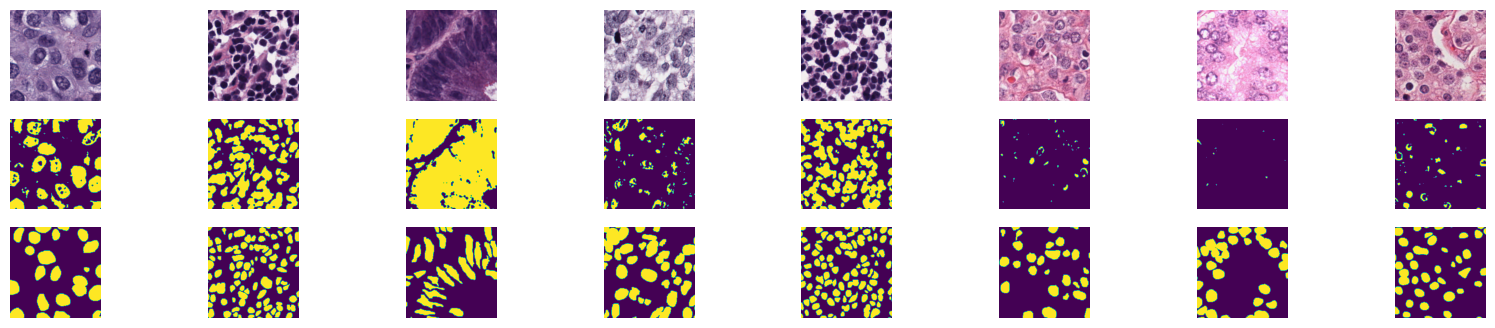

In [44]:
show_pic(model, images, name="hybrid_loss_data_aug_lr_scheduling")

In [45]:
# @title Apply Regularization

# Weight Decay (L2 Regularization to encourage smaller weight)

model = UNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 50

aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform = transform)
train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

model = model.to(device=device)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler, name="hybrid_loss_data_aug_lr_scheduling_weight_decay")

Epoch 1/50: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

Epoch 1, Training Loss: 0.5654


Current Learning Rate: 0.001000
Epoch 1, Validation Loss: 0.4674, Accuracy: 0.8046
New best model saved (Accuracy: 0.8046)


Epoch 2/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 2, Training Loss: 0.4949


Current Learning Rate: 0.001000
Epoch 2, Validation Loss: 0.4505, Accuracy: 0.8102
New best model saved (Accuracy: 0.8102)


Epoch 3/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 3, Training Loss: 0.4830


Current Learning Rate: 0.001000
Epoch 3, Validation Loss: 0.4495, Accuracy: 0.8089


Epoch 4/50: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

Epoch 4, Training Loss: 0.4599


Current Learning Rate: 0.001000
Epoch 4, Validation Loss: 0.4145, Accuracy: 0.7988


Epoch 5/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 5, Training Loss: 0.4176


Current Learning Rate: 0.001000
Epoch 5, Validation Loss: 0.3775, Accuracy: 0.7833


Epoch 6/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 6, Training Loss: 0.3849


Current Learning Rate: 0.001000
Epoch 6, Validation Loss: 0.3653, Accuracy: 0.8077


Epoch 7/50: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

Epoch 7, Training Loss: 0.3758


Current Learning Rate: 0.001000
Epoch 7, Validation Loss: 0.3624, Accuracy: 0.7976


Epoch 8/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 8, Training Loss: 0.3850


Current Learning Rate: 0.001000
Epoch 8, Validation Loss: 0.3317, Accuracy: 0.8089


Epoch 9/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 9, Training Loss: 0.3661


Current Learning Rate: 0.001000
Epoch 9, Validation Loss: 0.3430, Accuracy: 0.8323
New best model saved (Accuracy: 0.8323)


Epoch 10/50: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

Epoch 10, Training Loss: 0.3836


Current Learning Rate: 0.001000
Epoch 10, Validation Loss: 0.3620, Accuracy: 0.7868


Epoch 11/50: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

Epoch 11, Training Loss: 0.3813


Current Learning Rate: 0.001000
Epoch 11, Validation Loss: 0.3538, Accuracy: 0.8037


Epoch 12/50: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

Epoch 12, Training Loss: 0.3477


Current Learning Rate: 0.001000
Epoch 12, Validation Loss: 0.3136, Accuracy: 0.8336
New best model saved (Accuracy: 0.8336)


Epoch 13/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 13, Training Loss: 0.3493


Current Learning Rate: 0.001000
Epoch 13, Validation Loss: 0.3486, Accuracy: 0.7905


Epoch 14/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 14, Training Loss: 0.3382


Current Learning Rate: 0.001000
Epoch 14, Validation Loss: 0.3408, Accuracy: 0.8189


Epoch 15/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 15, Training Loss: 0.3339


Current Learning Rate: 0.001000
Epoch 15, Validation Loss: 0.3661, Accuracy: 0.7961


Epoch 16/50: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Epoch 16, Training Loss: 0.3461


Current Learning Rate: 0.001000
Epoch 16, Validation Loss: 0.3283, Accuracy: 0.8325


Epoch 17/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 17, Training Loss: 0.3407


Current Learning Rate: 0.001000
Epoch 17, Validation Loss: 0.3332, Accuracy: 0.8395
New best model saved (Accuracy: 0.8395)


Epoch 18/50: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

Epoch 18, Training Loss: 0.3375


Current Learning Rate: 0.001000
Epoch 18, Validation Loss: 0.3115, Accuracy: 0.8503
New best model saved (Accuracy: 0.8503)


Epoch 19/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 19, Training Loss: 0.3456


Current Learning Rate: 0.001000
Epoch 19, Validation Loss: 0.3023, Accuracy: 0.8623
New best model saved (Accuracy: 0.8623)


Epoch 20/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 20, Training Loss: 0.3387


Current Learning Rate: 0.001000
Epoch 20, Validation Loss: 0.3177, Accuracy: 0.8633
New best model saved (Accuracy: 0.8633)


Epoch 21/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 21, Training Loss: 0.3536


Current Learning Rate: 0.001000
Epoch 21, Validation Loss: 0.2916, Accuracy: 0.8849
New best model saved (Accuracy: 0.8849)


Epoch 22/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 22, Training Loss: 0.3330


Current Learning Rate: 0.001000
Epoch 22, Validation Loss: 0.3092, Accuracy: 0.8526


Epoch 23/50: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

Epoch 23, Training Loss: 0.3340


Current Learning Rate: 0.001000
Epoch 23, Validation Loss: 0.3029, Accuracy: 0.8549


Epoch 24/50: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

Epoch 24, Training Loss: 0.3321


Current Learning Rate: 0.001000
Epoch 24, Validation Loss: 0.3024, Accuracy: 0.8651


Epoch 25/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 25, Training Loss: 0.3192


Current Learning Rate: 0.001000
Epoch 25, Validation Loss: 0.3105, Accuracy: 0.8492


Epoch 26/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 26, Training Loss: 0.3186


Current Learning Rate: 0.001000
Epoch 26, Validation Loss: 0.2800, Accuracy: 0.8681


Epoch 27/50: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

Epoch 27, Training Loss: 0.3274


Current Learning Rate: 0.001000
Epoch 27, Validation Loss: 0.3309, Accuracy: 0.8294


Epoch 28/50: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

Epoch 28, Training Loss: 0.3416


Current Learning Rate: 0.001000
Epoch 28, Validation Loss: 0.2901, Accuracy: 0.8804


Epoch 29/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 29, Training Loss: 0.3226


Current Learning Rate: 0.001000
Epoch 29, Validation Loss: 0.3213, Accuracy: 0.8433


Epoch 30/50: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

Epoch 30, Training Loss: 0.3286


Current Learning Rate: 0.001000
Epoch 30, Validation Loss: 0.3111, Accuracy: 0.8419


Epoch 31/50: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

Epoch 31, Training Loss: 0.3350


Current Learning Rate: 0.001000
Epoch 31, Validation Loss: 0.3524, Accuracy: 0.8079


Epoch 32/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 32, Training Loss: 0.3188


Current Learning Rate: 0.001000
Epoch 32, Validation Loss: 0.2793, Accuracy: 0.8674


Epoch 33/50: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

Epoch 33, Training Loss: 0.3221


Current Learning Rate: 0.001000
Epoch 33, Validation Loss: 0.2903, Accuracy: 0.8671


Epoch 34/50: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

Epoch 34, Training Loss: 0.3158


Current Learning Rate: 0.001000
Epoch 34, Validation Loss: 0.3020, Accuracy: 0.8527


Epoch 35/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

Epoch 35, Training Loss: 0.3316


Current Learning Rate: 0.001000
Epoch 35, Validation Loss: 0.3008, Accuracy: 0.8518


Epoch 36/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 36, Training Loss: 0.3130


Current Learning Rate: 0.001000
Epoch 36, Validation Loss: 0.3215, Accuracy: 0.8416


Epoch 37/50: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Epoch 37, Training Loss: 0.3127


Current Learning Rate: 0.001000
Epoch 37, Validation Loss: 0.2710, Accuracy: 0.8810


Epoch 38/50: 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

Epoch 38, Training Loss: 0.3414


Current Learning Rate: 0.001000
Epoch 38, Validation Loss: 0.3717, Accuracy: 0.8020


Epoch 39/50: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

Epoch 39, Training Loss: 0.3315


Current Learning Rate: 0.001000
Epoch 39, Validation Loss: 0.2849, Accuracy: 0.8885
New best model saved (Accuracy: 0.8885)


Epoch 40/50: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Epoch 40, Training Loss: 0.3289


Current Learning Rate: 0.001000
Epoch 40, Validation Loss: 0.3032, Accuracy: 0.8703


Epoch 41/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 41, Training Loss: 0.3192


Current Learning Rate: 0.001000
Epoch 41, Validation Loss: 0.3063, Accuracy: 0.8508


Epoch 42/50: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

Epoch 42, Training Loss: 0.3186


Current Learning Rate: 0.001000
Epoch 42, Validation Loss: 0.3089, Accuracy: 0.8306


Epoch 43/50: 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

Epoch 43, Training Loss: 0.3251


Current Learning Rate: 0.001000
Epoch 43, Validation Loss: 0.2664, Accuracy: 0.8797


Epoch 44/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 44, Training Loss: 0.3386


Current Learning Rate: 0.001000
Epoch 44, Validation Loss: 0.3059, Accuracy: 0.8699


Epoch 45/50: 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

Epoch 45, Training Loss: 0.3105


Current Learning Rate: 0.001000
Epoch 45, Validation Loss: 0.2842, Accuracy: 0.8673


Epoch 46/50: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Epoch 46, Training Loss: 0.3181


Current Learning Rate: 0.001000
Epoch 46, Validation Loss: 0.2975, Accuracy: 0.8663


Epoch 47/50: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

Epoch 47, Training Loss: 0.3418


Current Learning Rate: 0.001000
Epoch 47, Validation Loss: 0.2909, Accuracy: 0.8768


Epoch 48/50: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Epoch 48, Training Loss: 0.3350


Current Learning Rate: 0.001000
Epoch 48, Validation Loss: 0.2799, Accuracy: 0.8821


Epoch 49/50: 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

Epoch 49, Training Loss: 0.3125


Current Learning Rate: 0.000500
Epoch 49, Validation Loss: 0.3291, Accuracy: 0.8631


Epoch 50/50: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]

Epoch 50, Training Loss: 0.3275


Current Learning Rate: 0.000500
Epoch 50, Validation Loss: 0.3458, Accuracy: 0.8466
Best model saved with accuracy 0.8885


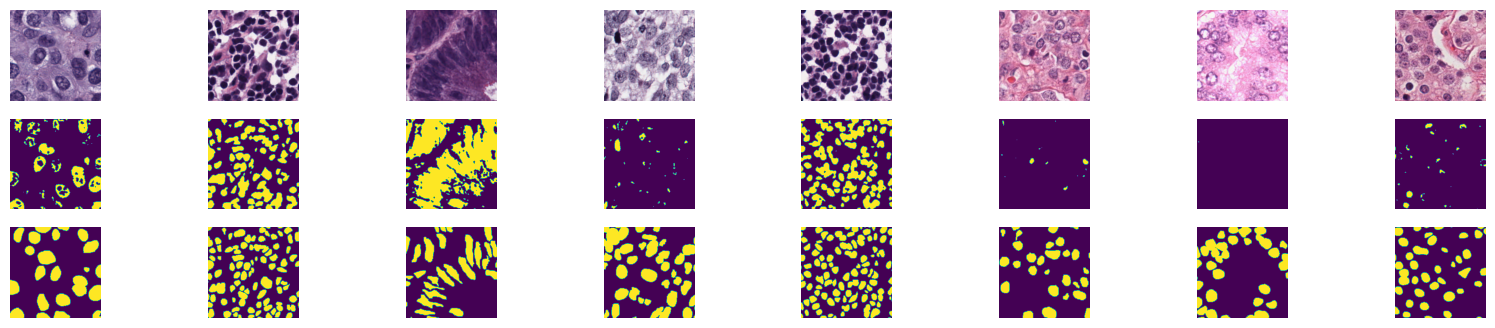

In [46]:
# @title Visualize after Regularization

show_pic(model, images, name="hybrid_loss_data_aug_lr_scheduling_weight_decay")

In [47]:
# @title Increase Batchsize

model = UNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 50

aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform = transform)
train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2) # Doesn't matter here since I'm not updating gradient

model = model.to(device=device)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler, name="hybrid_loss_data_aug_lr_scheduling_weight_decay_batch_increase")

Epoch 1/50: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

Epoch 1, Training Loss: 0.5996


Current Learning Rate: 0.001000
Epoch 1, Validation Loss: 0.5713, Accuracy: 0.7155
New best model saved (Accuracy: 0.7155)


Epoch 2/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 2, Training Loss: 0.5501


Current Learning Rate: 0.001000
Epoch 2, Validation Loss: 0.5885, Accuracy: 0.6949


Epoch 3/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 3, Training Loss: 0.5082


Current Learning Rate: 0.001000
Epoch 3, Validation Loss: 0.5477, Accuracy: 0.6938


Epoch 4/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 4, Training Loss: 0.4859


Current Learning Rate: 0.001000
Epoch 4, Validation Loss: 0.5226, Accuracy: 0.7253
New best model saved (Accuracy: 0.7253)


Epoch 5/50: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

Epoch 5, Training Loss: 0.4712


Current Learning Rate: 0.001000
Epoch 5, Validation Loss: 0.5067, Accuracy: 0.7279
New best model saved (Accuracy: 0.7279)


Epoch 6/50: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

Epoch 6, Training Loss: 0.4637


Current Learning Rate: 0.001000
Epoch 6, Validation Loss: 0.4856, Accuracy: 0.7316
New best model saved (Accuracy: 0.7316)


Epoch 7/50: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

Epoch 7, Training Loss: 0.4454


Current Learning Rate: 0.001000
Epoch 7, Validation Loss: 0.4744, Accuracy: 0.7305


Epoch 8/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 8, Training Loss: 0.4153


Current Learning Rate: 0.001000
Epoch 8, Validation Loss: 0.4502, Accuracy: 0.7264


Epoch 9/50: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

Epoch 9, Training Loss: 0.3961


Current Learning Rate: 0.001000
Epoch 9, Validation Loss: 0.4008, Accuracy: 0.7669
New best model saved (Accuracy: 0.7669)


Epoch 10/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 10, Training Loss: 0.3846


Current Learning Rate: 0.001000
Epoch 10, Validation Loss: 0.4046, Accuracy: 0.7465


Epoch 11/50: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Epoch 11, Training Loss: 0.3752


Current Learning Rate: 0.001000
Epoch 11, Validation Loss: 0.3942, Accuracy: 0.7283


Epoch 12/50: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

Epoch 12, Training Loss: 0.3784


Current Learning Rate: 0.001000
Epoch 12, Validation Loss: 0.4245, Accuracy: 0.7156


Epoch 13/50: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

Epoch 13, Training Loss: 0.3735


Current Learning Rate: 0.001000
Epoch 13, Validation Loss: 0.3883, Accuracy: 0.7525


Epoch 14/50: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

Epoch 14, Training Loss: 0.3560


Current Learning Rate: 0.001000
Epoch 14, Validation Loss: 0.4728, Accuracy: 0.7111


Epoch 15/50: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

Epoch 15, Training Loss: 0.3508


Current Learning Rate: 0.001000
Epoch 15, Validation Loss: 0.4087, Accuracy: 0.7154


Epoch 16/50: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Epoch 16, Training Loss: 0.3818


Current Learning Rate: 0.001000
Epoch 16, Validation Loss: 0.3860, Accuracy: 0.7464


Epoch 17/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 17, Training Loss: 0.3601


Current Learning Rate: 0.001000
Epoch 17, Validation Loss: 0.3975, Accuracy: 0.8215
New best model saved (Accuracy: 0.8215)


Epoch 18/50: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

Epoch 18, Training Loss: 0.3475


Current Learning Rate: 0.001000
Epoch 18, Validation Loss: 0.4071, Accuracy: 0.8075


Epoch 19/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 19, Training Loss: 0.3744


Current Learning Rate: 0.001000
Epoch 19, Validation Loss: 0.3704, Accuracy: 0.8224
New best model saved (Accuracy: 0.8224)


Epoch 20/50: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

Epoch 20, Training Loss: 0.3584


Current Learning Rate: 0.001000
Epoch 20, Validation Loss: 0.3704, Accuracy: 0.8430
New best model saved (Accuracy: 0.8430)


Epoch 21/50: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Epoch 21, Training Loss: 0.3782


Current Learning Rate: 0.001000
Epoch 21, Validation Loss: 0.4709, Accuracy: 0.8019


Epoch 22/50: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

Epoch 22, Training Loss: 0.3484


Current Learning Rate: 0.001000
Epoch 22, Validation Loss: 0.3933, Accuracy: 0.7971


Epoch 23/50: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

Epoch 23, Training Loss: 0.3543


Current Learning Rate: 0.001000
Epoch 23, Validation Loss: 0.3701, Accuracy: 0.8238


Epoch 24/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 24, Training Loss: 0.3376


Current Learning Rate: 0.001000
Epoch 24, Validation Loss: 0.4085, Accuracy: 0.8093


Epoch 25/50: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

Epoch 25, Training Loss: 0.3393


Current Learning Rate: 0.001000
Epoch 25, Validation Loss: 0.3732, Accuracy: 0.8529
New best model saved (Accuracy: 0.8529)


Epoch 26/50: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

Epoch 26, Training Loss: 0.3252


Current Learning Rate: 0.001000
Epoch 26, Validation Loss: 0.3495, Accuracy: 0.8326


Epoch 27/50: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

Epoch 27, Training Loss: 0.3316


Current Learning Rate: 0.001000
Epoch 27, Validation Loss: 0.3724, Accuracy: 0.8078


Epoch 28/50: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

Epoch 28, Training Loss: 0.3180


Current Learning Rate: 0.001000
Epoch 28, Validation Loss: 0.3491, Accuracy: 0.8317


Epoch 29/50: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

Epoch 29, Training Loss: 0.3227


Current Learning Rate: 0.001000
Epoch 29, Validation Loss: 0.3323, Accuracy: 0.8395


Epoch 30/50: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

Epoch 30, Training Loss: 0.3195


Current Learning Rate: 0.001000
Epoch 30, Validation Loss: 0.3620, Accuracy: 0.8100


Epoch 31/50: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

Epoch 31, Training Loss: 0.3163


Current Learning Rate: 0.001000
Epoch 31, Validation Loss: 0.3593, Accuracy: 0.8380


Epoch 32/50: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Epoch 32, Training Loss: 0.3416


Current Learning Rate: 0.001000
Epoch 32, Validation Loss: 0.3630, Accuracy: 0.8328


Epoch 33/50: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

Epoch 33, Training Loss: 0.3062


Current Learning Rate: 0.001000
Epoch 33, Validation Loss: 0.3863, Accuracy: 0.8304


Epoch 34/50: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

Epoch 34, Training Loss: 0.3192


Current Learning Rate: 0.001000
Epoch 34, Validation Loss: 0.3446, Accuracy: 0.8197


Epoch 35/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 35, Training Loss: 0.3171


Current Learning Rate: 0.000500
Epoch 35, Validation Loss: 0.3377, Accuracy: 0.8269


Epoch 36/50: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

Epoch 36, Training Loss: 0.3153


Current Learning Rate: 0.000500
Epoch 36, Validation Loss: 0.3909, Accuracy: 0.8019


Epoch 37/50: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Epoch 37, Training Loss: 0.3013


Current Learning Rate: 0.000500
Epoch 37, Validation Loss: 0.3967, Accuracy: 0.8039


Epoch 38/50: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

Epoch 38, Training Loss: 0.3196


Current Learning Rate: 0.000500
Epoch 38, Validation Loss: 0.3497, Accuracy: 0.8363


Epoch 39/50: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

Epoch 39, Training Loss: 0.3053


Current Learning Rate: 0.000500
Epoch 39, Validation Loss: 0.3534, Accuracy: 0.8275


Epoch 40/50: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

Epoch 40, Training Loss: 0.2864


Current Learning Rate: 0.000500
Epoch 40, Validation Loss: 0.3653, Accuracy: 0.8296


Epoch 41/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 41, Training Loss: 0.3112


Current Learning Rate: 0.000250
Epoch 41, Validation Loss: 0.3756, Accuracy: 0.8225


Epoch 42/50: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Epoch 42, Training Loss: 0.3023


Current Learning Rate: 0.000250
Epoch 42, Validation Loss: 0.3950, Accuracy: 0.8092


Epoch 43/50: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Epoch 43, Training Loss: 0.3078


Current Learning Rate: 0.000250
Epoch 43, Validation Loss: 0.3685, Accuracy: 0.8143


Epoch 44/50: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]

Epoch 44, Training Loss: 0.3007


Current Learning Rate: 0.000250
Epoch 44, Validation Loss: 0.3594, Accuracy: 0.8109


Epoch 45/50: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

Epoch 45, Training Loss: 0.3101


Current Learning Rate: 0.000250
Epoch 45, Validation Loss: 0.3577, Accuracy: 0.8171


Epoch 46/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 46, Training Loss: 0.2977


Current Learning Rate: 0.000250
Epoch 46, Validation Loss: 0.3880, Accuracy: 0.8023


Epoch 47/50: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

Epoch 47, Training Loss: 0.2976


Current Learning Rate: 0.000125
Epoch 47, Validation Loss: 0.3486, Accuracy: 0.8363


Epoch 48/50: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

Epoch 48, Training Loss: 0.3107


Current Learning Rate: 0.000125
Epoch 48, Validation Loss: 0.3685, Accuracy: 0.8170


Epoch 49/50: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]

Epoch 49, Training Loss: 0.2997


Current Learning Rate: 0.000125
Epoch 49, Validation Loss: 0.3889, Accuracy: 0.7936


Epoch 50/50: 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

Epoch 50, Training Loss: 0.2987


Current Learning Rate: 0.000125
Epoch 50, Validation Loss: 0.3159, Accuracy: 0.8463
Best model saved with accuracy 0.8529


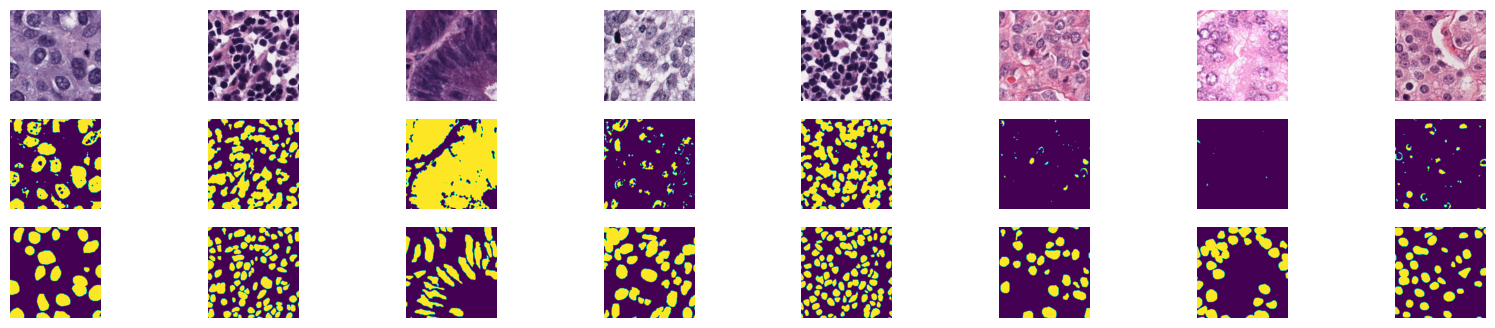

In [48]:
show_pic(model, images, name="hybrid_loss_data_aug_lr_scheduling_weight_decay_batch_increase")

In [50]:
# @title Reduce Batchsize back down to 8, Add Data Augmentation: Brightness/Contrast

transform = v2.Compose([v2.RandomCrop((256,256)), v2.RandomHorizontalFlip(), v2.RandomVerticalFlip(), v2.RandomRotation(180)])

aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform=transform, bright_contrast=True)
train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

model = UNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 50

model = model.to(device=device)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler, name="hybrid_loss_data_aug_lr_scheduling_weight_decay_bright_contrast")

Epoch 1/50: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

Epoch 1, Training Loss: 0.6211


Current Learning Rate: 0.001000
Epoch 1, Validation Loss: 0.5296, Accuracy: 0.7477
New best model saved (Accuracy: 0.7477)


Epoch 2/50: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

Epoch 2, Training Loss: 0.6665


Current Learning Rate: 0.001000
Epoch 2, Validation Loss: 0.5357, Accuracy: 0.7649
New best model saved (Accuracy: 0.7649)


Epoch 3/50: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

Epoch 3, Training Loss: 0.5365


Current Learning Rate: 0.001000
Epoch 3, Validation Loss: 0.5297, Accuracy: 0.7348


Epoch 4/50: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

Epoch 4, Training Loss: 0.5003


Current Learning Rate: 0.001000
Epoch 4, Validation Loss: 0.4867, Accuracy: 0.7839
New best model saved (Accuracy: 0.7839)


Epoch 5/50: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

Epoch 5, Training Loss: 0.4759


Current Learning Rate: 0.001000
Epoch 5, Validation Loss: 0.5103, Accuracy: 0.7614


Epoch 6/50: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

Epoch 6, Training Loss: 0.4617


Current Learning Rate: 0.001000
Epoch 6, Validation Loss: 0.4220, Accuracy: 0.7986
New best model saved (Accuracy: 0.7986)


Epoch 7/50: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

Epoch 7, Training Loss: 0.4356


Current Learning Rate: 0.001000
Epoch 7, Validation Loss: 0.4262, Accuracy: 0.7494


Epoch 8/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 8, Training Loss: 0.4143


Current Learning Rate: 0.001000
Epoch 8, Validation Loss: 0.5346, Accuracy: 0.7452


Epoch 9/50: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

Epoch 9, Training Loss: 5.6308


Current Learning Rate: 0.001000
Epoch 9, Validation Loss: 0.4101, Accuracy: 0.8089
New best model saved (Accuracy: 0.8089)


Epoch 10/50: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

Epoch 10, Training Loss: 0.4084


Current Learning Rate: 0.001000
Epoch 10, Validation Loss: 0.4346, Accuracy: 0.7678


Epoch 11/50: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

Epoch 11, Training Loss: 0.4143


Current Learning Rate: 0.001000
Epoch 11, Validation Loss: 0.4168, Accuracy: 0.7776


Epoch 12/50: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Epoch 12, Training Loss: 0.4196


Current Learning Rate: 0.001000
Epoch 12, Validation Loss: 0.4276, Accuracy: 0.7717


Epoch 13/50: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Epoch 13, Training Loss: 0.4130


Current Learning Rate: 0.001000
Epoch 13, Validation Loss: 0.4352, Accuracy: 0.7430


Epoch 14/50: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Epoch 14, Training Loss: 0.3983


Current Learning Rate: 0.001000
Epoch 14, Validation Loss: 0.4210, Accuracy: 0.7678


Epoch 15/50: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Epoch 15, Training Loss: 0.3841


Current Learning Rate: 0.001000
Epoch 15, Validation Loss: 0.3774, Accuracy: 0.8568
New best model saved (Accuracy: 0.8568)


Epoch 16/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 16, Training Loss: 0.3741


Current Learning Rate: 0.001000
Epoch 16, Validation Loss: 0.3848, Accuracy: 0.8562


Epoch 17/50: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

Epoch 17, Training Loss: 0.3815


Current Learning Rate: 0.001000
Epoch 17, Validation Loss: 0.4624, Accuracy: 0.8007


Epoch 18/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 18, Training Loss: 0.3837


Current Learning Rate: 0.001000
Epoch 18, Validation Loss: 0.3614, Accuracy: 0.8495


Epoch 19/50: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

Epoch 19, Training Loss: 0.3586


Current Learning Rate: 0.001000
Epoch 19, Validation Loss: 0.3267, Accuracy: 0.8713
New best model saved (Accuracy: 0.8713)


Epoch 20/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 20, Training Loss: 0.3722


Current Learning Rate: 0.001000
Epoch 20, Validation Loss: 0.3852, Accuracy: 0.8357


Epoch 21/50: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Epoch 21, Training Loss: 0.3586


Current Learning Rate: 0.001000
Epoch 21, Validation Loss: 0.3542, Accuracy: 0.8470


Epoch 22/50: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

Epoch 22, Training Loss: 0.3342


Current Learning Rate: 0.001000
Epoch 22, Validation Loss: 0.3631, Accuracy: 0.8404


Epoch 23/50: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

Epoch 23, Training Loss: 0.3413


Current Learning Rate: 0.001000
Epoch 23, Validation Loss: 0.3389, Accuracy: 0.8196


Epoch 24/50: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

Epoch 24, Training Loss: 1.5486


Current Learning Rate: 0.001000
Epoch 24, Validation Loss: 0.5224, Accuracy: 0.8147


Epoch 25/50: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

Epoch 25, Training Loss: 0.5671


Current Learning Rate: 0.000500
Epoch 25, Validation Loss: 0.6254, Accuracy: 0.8093


Epoch 26/50: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Epoch 26, Training Loss: 0.5024


Current Learning Rate: 0.000500
Epoch 26, Validation Loss: 0.4597, Accuracy: 0.8353


Epoch 27/50: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

Epoch 27, Training Loss: 0.4098


Current Learning Rate: 0.000500
Epoch 27, Validation Loss: 0.4256, Accuracy: 0.8246


Epoch 28/50: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

Epoch 28, Training Loss: 0.3744


Current Learning Rate: 0.000500
Epoch 28, Validation Loss: 0.3923, Accuracy: 0.8449


Epoch 29/50: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Epoch 29, Training Loss: 0.3643


Current Learning Rate: 0.000500
Epoch 29, Validation Loss: 0.3725, Accuracy: 0.8181


Epoch 30/50: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

Epoch 30, Training Loss: 0.3659


Current Learning Rate: 0.000500
Epoch 30, Validation Loss: 0.3421, Accuracy: 0.8601


Epoch 31/50: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

Epoch 31, Training Loss: 0.3694


Current Learning Rate: 0.000250
Epoch 31, Validation Loss: 0.3513, Accuracy: 0.8446


Epoch 32/50: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

Epoch 32, Training Loss: 0.3494


Current Learning Rate: 0.000250
Epoch 32, Validation Loss: 0.3635, Accuracy: 0.8357


Epoch 33/50: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

Epoch 33, Training Loss: 0.3477


Current Learning Rate: 0.000250
Epoch 33, Validation Loss: 0.3504, Accuracy: 0.8706


Epoch 34/50: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Epoch 34, Training Loss: 0.3512


Current Learning Rate: 0.000250
Epoch 34, Validation Loss: 0.3048, Accuracy: 0.8826
New best model saved (Accuracy: 0.8826)


Epoch 35/50: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

Epoch 35, Training Loss: 0.3495


Current Learning Rate: 0.000250
Epoch 35, Validation Loss: 0.3646, Accuracy: 0.8286


Epoch 36/50: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Epoch 36, Training Loss: 0.3744


Current Learning Rate: 0.000250
Epoch 36, Validation Loss: 0.3523, Accuracy: 0.8190


Epoch 37/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 37, Training Loss: 0.3357


Current Learning Rate: 0.000250
Epoch 37, Validation Loss: 0.3419, Accuracy: 0.8622


Epoch 38/50: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

Epoch 38, Training Loss: 0.3630


Current Learning Rate: 0.000250
Epoch 38, Validation Loss: 0.4151, Accuracy: 0.8301


Epoch 39/50: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

Epoch 39, Training Loss: 0.3573


Current Learning Rate: 0.000250
Epoch 39, Validation Loss: 0.3626, Accuracy: 0.8431


Epoch 40/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 40, Training Loss: 0.3686


Current Learning Rate: 0.000125
Epoch 40, Validation Loss: 0.4025, Accuracy: 0.8364


Epoch 41/50: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

Epoch 41, Training Loss: 0.3679


Current Learning Rate: 0.000125
Epoch 41, Validation Loss: 0.3448, Accuracy: 0.8568


Epoch 42/50: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

Epoch 42, Training Loss: 0.3548


Current Learning Rate: 0.000125
Epoch 42, Validation Loss: 0.3672, Accuracy: 0.8777


Epoch 43/50: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

Epoch 43, Training Loss: 0.3533


Current Learning Rate: 0.000125
Epoch 43, Validation Loss: 0.3728, Accuracy: 0.8216


Epoch 44/50: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Epoch 44, Training Loss: 0.3390


Current Learning Rate: 0.000125
Epoch 44, Validation Loss: 0.3874, Accuracy: 0.8451


Epoch 45/50: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

Epoch 45, Training Loss: 0.3706


Current Learning Rate: 0.000125
Epoch 45, Validation Loss: 0.3318, Accuracy: 0.8658


Epoch 46/50: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

Epoch 46, Training Loss: 0.3546


Current Learning Rate: 0.000063
Epoch 46, Validation Loss: 0.3595, Accuracy: 0.8603


Epoch 47/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 47, Training Loss: 0.3613


Current Learning Rate: 0.000063
Epoch 47, Validation Loss: 0.3958, Accuracy: 0.8242


Epoch 48/50: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

Epoch 48, Training Loss: 0.3500


Current Learning Rate: 0.000063
Epoch 48, Validation Loss: 0.3785, Accuracy: 0.8308


Epoch 49/50: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

Epoch 49, Training Loss: 0.3595


Current Learning Rate: 0.000063
Epoch 49, Validation Loss: 0.3377, Accuracy: 0.8425


Epoch 50/50: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Epoch 50, Training Loss: 0.3490


Current Learning Rate: 0.000063
Epoch 50, Validation Loss: 0.3687, Accuracy: 0.8288
Best model saved with accuracy 0.8826


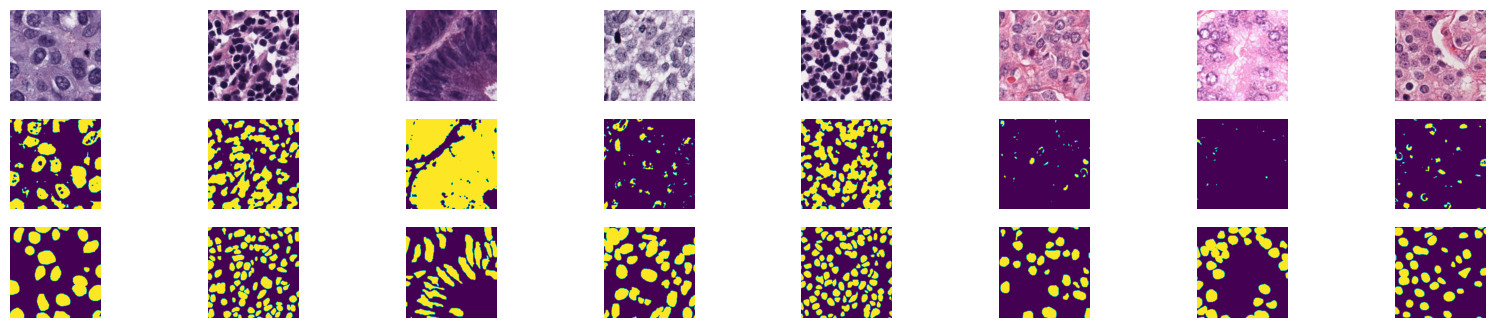

In [51]:
show_pic(model, images, name="hybrid_loss_data_aug_lr_scheduling_weight_decay_bright_contrast")

In [53]:
# @title Try to find the best method

for i in range(10):
    transform = v2.Compose([v2.RandomCrop((256,256)), v2.RandomHorizontalFlip(), v2.RandomVerticalFlip(), v2.RandomRotation(180)])
    
    aug_dataset = MoNuSegDataset('MoNuSeg/MoNuSeg 2018 Training Data', transform=transform, bright_contrast=True)
    train_dataset, val_dataset = random_split(aug_dataset, [0.85, 0.15])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)
    
    model = UNet()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    epochs = 50
    
    model = model.to(device=device)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    train(epochs, model, hybrid_loss, optimizer, train_loader, val_loader, lr_scheduler = scheduler, name="hybrid_loss_data_aug_lr_scheduling_weight_decay_bright_contrast")

Epoch 1/50: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

Epoch 1, Training Loss: 0.5813


Epoch 1, Validation Loss: 0.5175, Accuracy: 0.7604
New best model saved (Accuracy: 0.7604)


Epoch 2/50: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Epoch 2, Training Loss: 0.4908


Epoch 2, Validation Loss: 0.5130, Accuracy: 0.7146


Epoch 3/50: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

Epoch 3, Training Loss: 0.4589


Epoch 3, Validation Loss: 0.5043, Accuracy: 0.7166


Epoch 4/50: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Epoch 4, Training Loss: 0.4221


Epoch 4, Validation Loss: 0.4169, Accuracy: 0.7382


Epoch 5/50: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

Epoch 5, Training Loss: 0.4103


Epoch 5, Validation Loss: 0.4141, Accuracy: 0.7464


Epoch 6/50: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

Epoch 6, Training Loss: 0.3796


Epoch 6, Validation Loss: 0.4195, Accuracy: 0.7326


Epoch 7/50: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Epoch 7, Training Loss: 0.3639


Epoch 7, Validation Loss: 0.4020, Accuracy: 0.7483


Epoch 8/50: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Epoch 8, Training Loss: 0.3849


Epoch 8, Validation Loss: 0.4354, Accuracy: 0.7755
New best model saved (Accuracy: 0.7755)


Epoch 9/50: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

Epoch 9, Training Loss: 0.3675


Epoch 9, Validation Loss: 0.4176, Accuracy: 0.8067
New best model saved (Accuracy: 0.8067)


Epoch 10/50: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

Epoch 10, Training Loss: 0.3481


Epoch 10, Validation Loss: 0.4222, Accuracy: 0.7881


Epoch 11/50: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

Epoch 11, Training Loss: 0.3569


Epoch 11, Validation Loss: 0.3788, Accuracy: 0.7834


Epoch 12/50: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

Epoch 12, Training Loss: 0.3303


Epoch 12, Validation Loss: 0.4178, Accuracy: 0.8114
New best model saved (Accuracy: 0.8114)


Epoch 13/50: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

Epoch 13, Training Loss: 0.3528


Epoch 13, Validation Loss: 0.3903, Accuracy: 0.8000


Epoch 14/50: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

Epoch 14, Training Loss: 0.3305


Epoch 14, Validation Loss: 0.3647, Accuracy: 0.8360
New best model saved (Accuracy: 0.8360)


Epoch 15/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 15, Training Loss: 0.3567


Epoch 15, Validation Loss: 0.3856, Accuracy: 0.8443
New best model saved (Accuracy: 0.8443)


Epoch 16/50: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Epoch 16, Training Loss: 0.3449


Epoch 16, Validation Loss: 0.3226, Accuracy: 0.8579
New best model saved (Accuracy: 0.8579)


Epoch 17/50: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

Epoch 17, Training Loss: 0.3251


Epoch 17, Validation Loss: 0.3246, Accuracy: 0.8662
New best model saved (Accuracy: 0.8662)


Epoch 18/50: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

Epoch 18, Training Loss: 0.3233


Epoch 18, Validation Loss: 0.3525, Accuracy: 0.8522


Epoch 19/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 19, Training Loss: 0.3010


Epoch 19, Validation Loss: 0.4132, Accuracy: 0.7982


Epoch 20/50: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Epoch 20, Training Loss: 0.3391


Epoch 20, Validation Loss: 0.3718, Accuracy: 0.8108


Epoch 21/50: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

Epoch 21, Training Loss: 0.3417


Epoch 21, Validation Loss: 0.4342, Accuracy: 0.8322


Epoch 22/50: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]

Epoch 22, Training Loss: 0.3255


Epoch 22, Validation Loss: 0.3255, Accuracy: 0.8557


Epoch 23/50: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

Epoch 23, Training Loss: 0.3280


Epoch 23, Validation Loss: 0.3631, Accuracy: 0.8430


Epoch 24/50: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

Epoch 24, Training Loss: 0.3461


Epoch 24, Validation Loss: 0.4273, Accuracy: 0.7781


Epoch 25/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 25, Training Loss: 0.3140


Epoch 25, Validation Loss: 0.3638, Accuracy: 0.8244


Epoch 26/50: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Epoch 26, Training Loss: 0.3235


Epoch 26, Validation Loss: 0.3695, Accuracy: 0.8206


Epoch 27/50: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

Epoch 27, Training Loss: 0.3299


Epoch 27, Validation Loss: 0.3409, Accuracy: 0.8554


Epoch 28/50: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

Epoch 28, Training Loss: 0.3386


Epoch 28, Validation Loss: 0.3829, Accuracy: 0.8365


Epoch 29/50: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

Epoch 29, Training Loss: 0.3167


Epoch 29, Validation Loss: 0.3587, Accuracy: 0.8332


Epoch 30/50: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

Epoch 30, Training Loss: 0.3227


Epoch 30, Validation Loss: 0.2970, Accuracy: 0.8708
New best model saved (Accuracy: 0.8708)


Epoch 31/50: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

Epoch 31, Training Loss: 0.3290


Epoch 31, Validation Loss: 0.3243, Accuracy: 0.8448


Epoch 32/50: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

Epoch 32, Training Loss: 0.3293


Epoch 32, Validation Loss: 0.4162, Accuracy: 0.8202


Epoch 33/50: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]

Epoch 33, Training Loss: 0.3240


Epoch 33, Validation Loss: 0.3866, Accuracy: 0.7928


Epoch 34/50: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

Epoch 34, Training Loss: 0.3162


Epoch 34, Validation Loss: 0.3173, Accuracy: 0.8729
New best model saved (Accuracy: 0.8729)


Epoch 35/50: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

Epoch 35, Training Loss: 0.3289


Epoch 35, Validation Loss: 0.3354, Accuracy: 0.8541


Epoch 36/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 36, Training Loss: 0.3238


Epoch 36, Validation Loss: 0.3452, Accuracy: 0.8205


Epoch 37/50: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

Epoch 37, Training Loss: 0.3149


Epoch 37, Validation Loss: 0.3801, Accuracy: 0.8213


Epoch 38/50: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]

Epoch 38, Training Loss: 0.3486


Epoch 38, Validation Loss: 0.3495, Accuracy: 0.8276


Epoch 39/50: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Epoch 39, Training Loss: 0.3429


Epoch 39, Validation Loss: 0.3528, Accuracy: 0.8388


Epoch 40/50: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

Epoch 40, Training Loss: 0.3463


Epoch 40, Validation Loss: 0.3778, Accuracy: 0.8552


Epoch 41/50: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

Epoch 41, Training Loss: 0.3100


Epoch 41, Validation Loss: 0.3869, Accuracy: 0.8480


Epoch 42/50: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

Epoch 42, Training Loss: 0.3237


Epoch 42, Validation Loss: 0.3520, Accuracy: 0.8203


Epoch 43/50: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

Epoch 43, Training Loss: 0.3248


Epoch 43, Validation Loss: 0.3663, Accuracy: 0.8281


Epoch 44/50: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]

Epoch 44, Training Loss: 0.3206


Epoch 44, Validation Loss: 0.3711, Accuracy: 0.8571


Epoch 45/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 45, Training Loss: 0.3339


Epoch 45, Validation Loss: 0.3258, Accuracy: 0.8544


Epoch 46/50: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

Epoch 46, Training Loss: 0.3277


Epoch 46, Validation Loss: 0.3089, Accuracy: 0.8633


Epoch 47/50: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]

Epoch 47, Training Loss: 0.3178


Epoch 47, Validation Loss: 0.3236, Accuracy: 0.8725


Epoch 48/50: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

Epoch 48, Training Loss: 0.3374


Epoch 48, Validation Loss: 0.3630, Accuracy: 0.8340


Epoch 49/50: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

Epoch 49, Training Loss: 0.3204


Epoch 49, Validation Loss: 0.3418, Accuracy: 0.8489


Epoch 50/50: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

Epoch 50, Training Loss: 0.3194


Epoch 50, Validation Loss: 0.3331, Accuracy: 0.8558
Best model saved with accuracy 0.8729
